In [1]:
import xlrd
import numpy as np 
import pandas as pd 
import geopandas as gpd 
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
!which python

/home/bingyu/anaconda3/envs/py38/bin/python


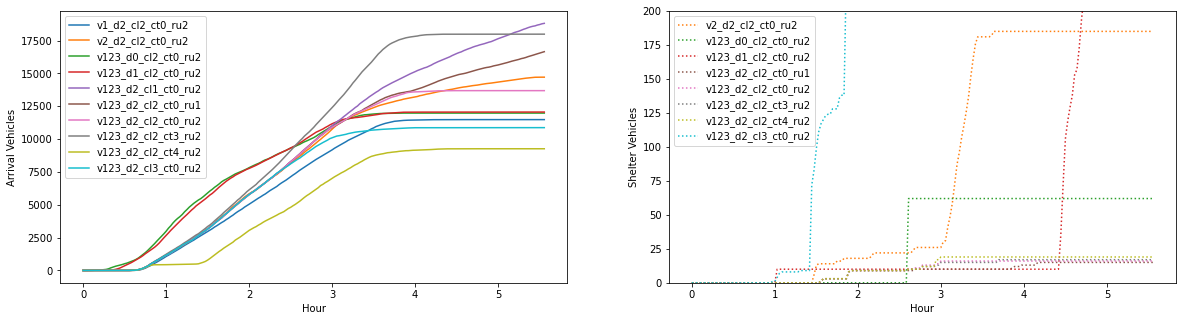

In [8]:
fig, ax = plt.subplots(1,2,figsize=(20, 5))
for vphh_id in ['1', '2', '123']:
    for dept_id in ['0', '1', '2']:
        for clos_id in ['1', '2', '3']:
            for contra_id in ['0', '3', '4']:
                for rout_id in ['1', '2']:
                    scen_nm = "v{}_d{}_cl{}_ct{}_ru{}".format(vphh_id, dept_id, clos_id, contra_id, rout_id)
                    try:
                        t_stats = pd.read_csv('t_stats/t_stats_{}.csv'.format(scen_nm))
                    except FileNotFoundError:
                        continue
                    t_stats['shelter_tot'] = t_stats['shelter'].cumsum()
                    t_stats = t_stats.loc[t_stats['t']<=20000]
                    arrival_curve = ax[0].plot(t_stats['t']/3600, t_stats['arr'], label=scen_nm)
                    if np.max(t_stats['shelter'])>1:
                        shelter_curve = ax[1].plot(t_stats['t']/3600, t_stats['shelter'], ls=':', color=ax[0].get_lines()[-1].get_c(), label=scen_nm)
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Arrival Vehicles')
ax[0].legend()
ax[1].set_ylim([0, 300])
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Shelter Vehicles')
ax[1].legend()
plt.show()

,t,arr,shelter,move,avg_fdist,neg_fdist,out_evac_zone_cnts,out_evac_buffer_cnts,shelter_tot
122,12200,12808,4339,78,0,2220,859,804,285257
123,12300,12922,4442,82,0,2017,849,791,289699
124,12400,13026,4509,79,0,1848,847,789,294208
125,12500,13123,4585,78,0,1670,852,796,298793
126,12600,13244,4661,74,0,1490,833,776,303454


,t,arr,shelter,move,avg_fdist,neg_fdist,out_evac_zone_cnts,out_evac_buffer_cnts,shelter_tot
122,12200,13291,2786,84,0,3278,888,820,163314
123,12300,13396,2867,87,0,3095,888,820,166181
124,12400,13499,2914,80,0,2940,891,823,169095
125,12500,13611,2962,87,0,2787,882,813,172057
126,12600,13714,3015,78,0,2631,884,813,175072


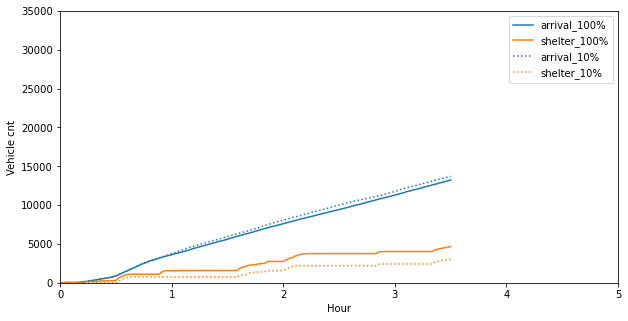

In [5]:
scen_nm = 'cawfe_1'
t_stats = pd.read_csv('t_stats/t_stats_{}.csv'.format(scen_nm))
t_stats['shelter_tot'] = t_stats['shelter'].cumsum()
t_stats = t_stats.loc[t_stats['t']<=12600]
display(t_stats.tail())

scen_nm = 'cawfe_0.1'
t_stats_2 = pd.read_csv('t_stats/t_stats_{}.csv'.format(scen_nm))
t_stats_2['shelter_tot'] = t_stats_2['shelter'].cumsum()
display(t_stats_2.tail())

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_stats['t']/3600, t_stats['arr'], label='arrival_100%')
ax.plot(t_stats['t']/3600, t_stats['shelter'], label='shelter_100%')
# ax.plot(t_stats['t']/3600, t_stats['out_evac_buffer_cnts'], label='out_10%')

ax.plot(t_stats_2['t']/3600, t_stats_2['arr'], ls=':', c=u'#1f77b4', label='arrival_10%')
ax.plot(t_stats_2['t']/3600, t_stats_2['shelter'], ls=':', c=u'#ff7f0e', label='shelter_10%')
# ax.plot(t_stats_2['t']/3600, t_stats_2['out_evac_buffer_cnts'], ls=':', c=u'#2ca02c', label='out_1%')

ax.set_xlim([0,5])
ax.set_ylim([0,35000])
plt.xlabel('Hour')
plt.ylabel('Vehicle cnt')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd 
from shapely.wkt import loads 
import contextily as ctx
from keplergl import KeplerGl

def make_map(queue_gdf):
    # make map
    # with open('keplergl_config.json') as jsonfile:
    #     map_config = json.load(jsonfile)
    map_queue= KeplerGl(height=400, config=map_config)
    # map_vehicles = KeplerGl(height=400)
    map_vehicles.add_data(data=queue_vehicle_position_gdf, name='queue vehicles')

    return map_vehicles

In [ ]:
# link congestion status
scen_nm = 'cawfe_1'
queue_stats = pd.read_csv('../network_inputs/butte_edges_sim.csv')
queue_stats['link_id'] = queue_stats['eid']
queue_stats = queue_stats[['link_id', 'length', 'lanes', 'geometry']].copy()
queue_stats['queue'] = 0
t_counts = 0
for t in range(1200, 8400, 1200):
    t_counts += 1
    link_stats_t = pd.read_csv('link_stats/link_stats_{}_t{}.csv'.format(scen_nm, t))
    queue_stats_t = link_stats_t.loc[link_stats_t['q']>0, ['link_id', 'q']]
    queue_stats = queue_stats.merge(queue_stats_t, how='left', on='link_id')
    queue_stats['queue'] += queue_stats['q']
    queue_stats = queue_stats[['link_id', 'length', 'lanes', 'queue', 'geometry']]
queue_stats['average_queue_length'] = queue_stats['queue']/t_counts
queue_stats['average_queue_density'] = queue_stats['average_queue_length']/(queue_stats['length']*queue_stats['lanes'])
display(queue_stats[queue_stats['queue']>0].head())

queue_stats_gdf = gpd.GeoDataFrame(queue_stats, crs='epsg:4326', geometry=queue_stats['geometry'].map(loads)).to_crs(epsg=3857)
ax = queue_stats_gdf .plot(figsize=(10, 10), color='red')
ctx.add_basemap(ax)

In [ ]:
node_stats = pd.read_csv('node_stats/node_agent_cnts_real_full_c0.01_t3600.csv')
print(node_stats['status'].unique(), node_stats['arr_status'].unique())
display(node_stats.groupby(['status', 'arr_status']).size())
node_stats.head()

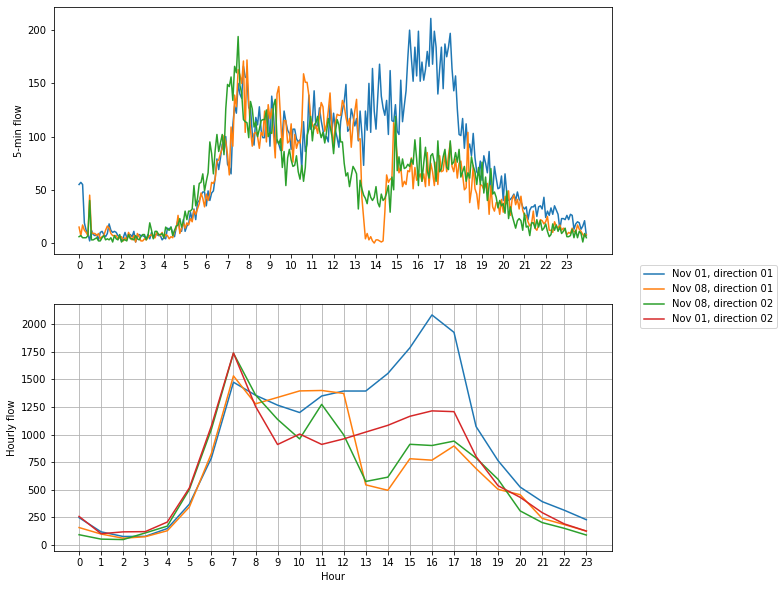

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
for date_dir in ['01_01', '08_01', '08_02']:
    validation = pd.read_excel('../validation/paradise_11_{}/pems_flow_11_{}.xlsx'.format(date_dir, date_dir))
    if date_dir[0:2] =='01': ref_date='2018-11-01T00:00:00'
    if date_dir[0:2] =='08': ref_date='2018-11-08T00:00:00'
    validation['time'] = validation['5 Minutes'] - np.datetime64(ref_date)
    validation['time'] = validation['time'].dt.total_seconds()
    # display(validation.head())
    
    ax[0].plot(validation['time']/3600, validation['Flow (Veh/5 Minutes)'], label='Nov {}, direction {}'.format(date_dir.split('_')[0], date_dir.split('_')[1]))
    ax[0].set_xticks(list(range(24)))
    ax[0].set_ylabel('5-min flow')
    
    validation_hr = validation.copy()
    validation_hr['hour'] = validation_hr['time']//3600
    validation_hr = validation_hr.groupby('hour').agg({'Flow (Veh/5 Minutes)': np.sum}).reset_index()

    ax[1].plot(validation_hr['hour'], validation_hr['Flow (Veh/5 Minutes)'], label='Nov {}, direction {}'.format(date_dir.split('_')[0], date_dir.split('_')[1]))
    ax[1].set_xticks(list(range(24)))
    
for date_dir in ['01_02']:
    validation = pd.read_excel('../validation/paradise_11_{}/pems_flow_11_{}.xlsx'.format(date_dir, date_dir))
    if date_dir[0:2] =='01': ref_date='2018-11-01T00:00:00'
    if date_dir[0:2] =='08': ref_date='2018-11-08T00:00:00'
    validation['hour'] = validation['Hour'] - np.datetime64(ref_date)
    validation['hour'] = validation['hour'].dt.total_seconds()/3600
    # display(validation.head())

    validation_hr = validation.copy()
    ax[1].plot(validation_hr['hour'], validation_hr['Flow (Veh/Hour)'], label='Nov {}, direction {}'.format(date_dir.split('_')[0], date_dir.split('_')[1]))
    ax[1].set_xticks(list(range(24)))
    ax[1].set_xlabel('Hour')
    ax[1].set_ylabel('Hourly flow')
    plt.legend(loc=[1.05, 0.9])
    plt.grid()
    plt.show()

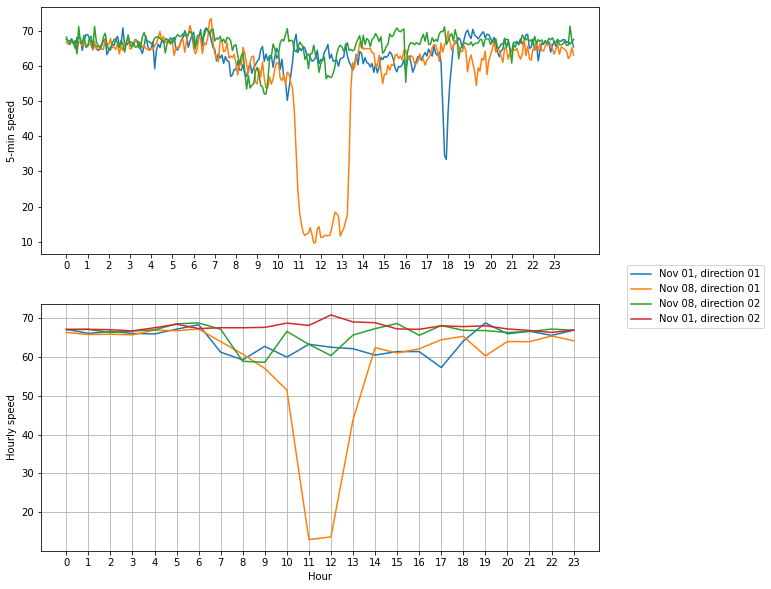

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
for date_dir in ['01_01', '08_01', '08_02']:
    validation = pd.read_excel('../validation/paradise_11_{}/pems_speed_11_{}.xlsx'.format(date_dir, date_dir))
    if date_dir[0:2] =='01': ref_date='2018-11-01T00:00:00'
    if date_dir[0:2] =='08': ref_date='2018-11-08T00:00:00'
    validation['time'] = validation['5 Minutes'] - np.datetime64(ref_date)
    validation['time'] = validation['time'].dt.total_seconds()
    # display(validation.head())
    
    ax[0].plot(validation['time']/3600, validation['Speed (mph)'], label=date_dir)
    ax[0].set_xticks(list(range(24)))
    ax[0].set_ylabel('5-min speed')
    
    validation_hr = validation.copy()
    validation_hr['hour'] = validation_hr['time']//3600
    validation_hr = validation_hr.groupby('hour').agg({'Speed (mph)': np.mean}).reset_index()
    # if date_dir=='08_01':
    #     display(validation_hr)

    ax[1].plot(validation_hr['hour'], validation_hr['Speed (mph)'], label='Nov {}, direction {}'.format(date_dir.split('_')[0], date_dir.split('_')[1]))
    ax[1].set_xticks(list(range(24)))
    
for date_dir in ['01_02']:
    validation = pd.read_excel('../validation/paradise_11_{}/pems_speed_11_{}.xlsx'.format(date_dir, date_dir))
    if date_dir[0:2] =='01': ref_date='2018-11-01T00:00:00'
    if date_dir[0:2] =='08': ref_date='2018-11-08T00:00:00'
    validation['hour'] = validation['Hour'] - np.datetime64(ref_date)
    validation['hour'] = validation['hour'].dt.total_seconds()/3600
    # display(validation.head())

    validation_hr = validation.copy()
    ax[1].plot(validation_hr['hour'], validation_hr['Speed (mph)'], label='Nov {}, direction {}'.format(date_dir.split('_')[0], date_dir.split('_')[1]))
    ax[1].set_xticks(list(range(24)))
    ax[1].set_xlabel('Hour')
    ax[1].set_ylabel('Hourly speed')

plt.legend(loc=[1.05, 0.9])
plt.grid()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
for scen_nm in ['ctm_c0.01', 'ctm_c0.01_d2', 'ctm_c0.01_d3']:
    transfer = pd.read_csv('transfer_stats/transfer_stats_{}.csv'.format(scen_nm))
    transfer['hour'] = transfer['t']//3600+8
    transfer['hourly_flow'] = transfer['29-33']-transfer['29-33'].shift(1)
    # display(transfer.head())
    transfer_hour = transfer.groupby('hour').agg({'hourly_flow': np.sum}).reset_index()
    
    ax.plot([7]+transfer_hour['hour'].values.tolist(), [0]+transfer_hour['hourly_flow'].values.tolist(), label=scen_nm)
    ax.set_xticks(list(range(24)))
    plt.legend()
    plt.grid()